In [1]:
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import re
import emoji

In [2]:
df = pd.read_csv('clean_reviews.csv')
df = df[['Title', 'Text']]
df

,Title,Text
0,Well worth a visit,"Always worth a visit to see the collection, to..."
1,Simply love this place,"An absolute delight, totally worth the visit. ..."
2,More 'Shart' than 'Art',"Noting that art appreciation is subjective, th..."
3,Wonderful Museum,Can’t believe I saw Starry Night ✨\n\n- Wonder...
4,Poorly managed museum with a great collection,"I am not an art expert, but love learning abou..."
...,...,...
9689,"If you have little time, it's better to spend ...",I expected the part dedicated to contemporary ...
9690,Great museum of modern art,It is really a modern art museum and not like ...
9691,Great museum in the part we could understand,"In fact, we spent more time on the 5th and 4th..."
9692,Confusion,"There's no question of art... organization, ho..."


In [3]:
# stopwords = set(stopwords.words('english')) | {
#     'a', 'about', 'above', 'again', 'all', 'am', 'an', 'and', 'any', 'as', 'at',
#     'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'by',
#     'doing', 'during', 'each', 'from', 'further', 'he', 'her', 'here', 'hers',
#     'herself', 'him', 'himself', 'his', 'i', 'in', 'into', 'is', 'it', "it's", 
#     'its', 'itself', 'me', 'my', 'myself', 'of', 'off', 'on', 'once', 'or',
#     'our', 'ours', 'ourselves', 'own', 's', 'she', "she's", 'some', 't', 'that', 
#     "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 
#     'these', 'they', 'this', 'those', 'through', 'to', 'up', 'we', 'were', 
#     'while', 'will', 'with', 'you', "you'd", "you'll", "you're", "you've", 'your', 
#     'yours', 'yourself', 'yourselves'
# }
stopwords = set(stopwords.words('english'))

In [4]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Handle empty or invalid input
    if not text or not isinstance(text, str):
        return ''
    
    # Detect language and filter non-English tweets
    try:
        if detect(text) != 'en':
            return ''
    except LangDetectException:
        return ''
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs, mentions, and unwanted characters
    text = re.sub(r'https?://\S+|www\.\S+|@\w+|[^a-zA-Z\s]', ' ', text).strip()
    
    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Reduce repeated characters (e.g., "cooooool" -> "cool")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Split concatenated camel-case or Pascal-case words
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    
    # Tokenize and process words
    tokens = text.split()
    
    # Remove short tweets and nonsense (e.g., "hello hello hello")
    if len(tokens) < 2 or len(set(tokens)) == 1:
        return ''
    
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if 2 < len(word) <= 17 and word not in stopwords
    ]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing
df['Text'] = df['Text'].apply(lambda x: preprocess(x))

df = df.reset_index(drop=True)

print(df['Text'])

0       always worth visit see collection say nothing ...
1       absolute delight totally worth visit expected ...
2       noting art appreciation subjective lovely nota...
3       believe saw starry night wonderful gift shop g...
4       art expert love learning art disappointed way ...
                              ...                        
9689    expected part dedicated contemporary art riche...
9690    really modern art museum like others pretend c...
9691    fact spent time floor painting dali frida gall...
9692    question art organization however another thin...
9693    say yet said written number painting richness ...
Name: Text, Length: 9694, dtype: object


In [5]:
# Tokenize the OriginalTweet column
df['Tokenized_Text'] = df['Text'].apply(
    lambda x: word_tokenize(x) if isinstance(x, str) and x.strip() else []
)

# Display the original and tokenized versions of the first few rows
df[['Text', 'Tokenized_Text']].head()

,Text,Tokenized_Text
0,always worth visit see collection say nothing ...,"[always, worth, visit, see, collection, say, n..."
1,absolute delight totally worth visit expected ...,"[absolute, delight, totally, worth, visit, exp..."
2,noting art appreciation subjective lovely nota...,"[noting, art, appreciation, subjective, lovely..."
3,believe saw starry night wonderful gift shop g...,"[believe, saw, starry, night, wonderful, gift,..."
4,art expert love learning art disappointed way ...,"[art, expert, love, learning, art, disappointe..."


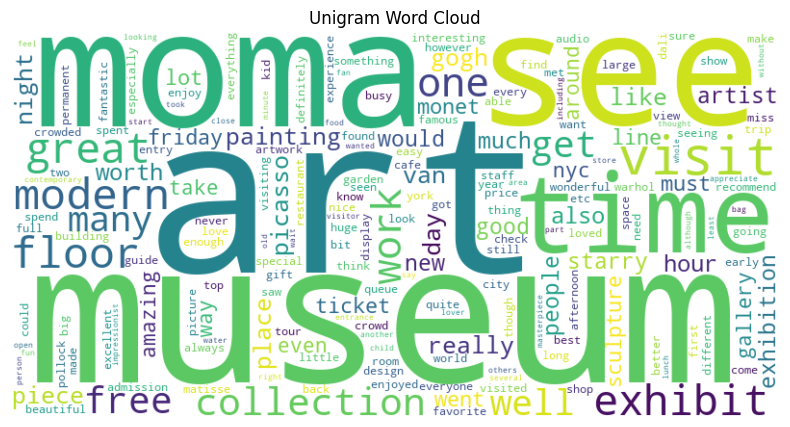

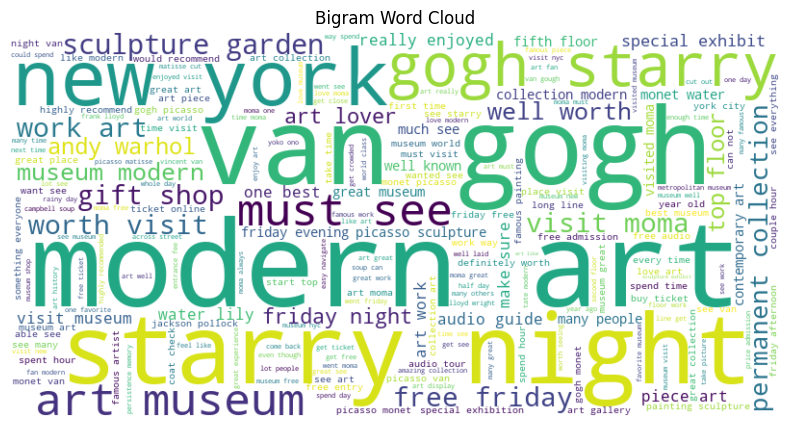

In [6]:
# Combine all cleaned tokens into a single list for analysis
all_tokens = [word for tokens in df['Tokenized_Text'] for word in tokens]

# Frequency analysis of unigrams
unigram_freq = Counter(all_tokens)

# Generate a word cloud for unigrams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title("Unigram Word Cloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Frequency analysis of bigrams
bigrams = Counter(zip(all_tokens[:-1], all_tokens[1:]))
bigram_freq = {f"{w1} {w2}": count for (w1, w2), count in bigrams.items()}

# Generate a word cloud for bigrams
bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq)

# Display the bigram cloud
plt.figure(figsize=(10, 5))
plt.title("Bigram Word Cloud")
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()